# Load Data and check recording


In [1]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import probeinterface as pi
from pathlib import Path
import pandas as pd 
import os, sys
import shutil
from pprint import pprint 
import time as time
%load_ext autoreload
%autoreload 2

import bombcell as bc

    
global_job_kwargs = dict(n_jobs=-3, chunk_duration="10s",progress_bar=True)
si.set_global_job_kwargs(**global_job_kwargs)


basefolder=r"D:\Data\3198-52\3198-52_recall_g0"
base_path = Path(basefolder)
metapath = base_path / 'Meta'
if not os.path.isdir(metapath):
   os.makedirs(metapath)



recording =  si.read_spikeglx(basefolder, stream_id='imec0.ap', load_sync_channel=False)
lfp = si.read_spikeglx(basefolder, stream_id='imec0.lf', load_sync_channel=False)
event =  si.read_spikeglx(basefolder, stream_id='nidq', load_sync_channel=False)
print(recording)





✅ ipywidgets available - interactive GUI ready
SpikeGLXRecordingExtractor: 384 channels - 29999.900000 Hz - 1 segments - 132,701,141 samples 
                            4,423.39s (1.23 hours) - int16 dtype - 94.92 GiB


# Preprocessing

In [2]:
#recording = si.ChannelSliceRecording(recording, channel_ids=recording.get_channel_ids()[180:330])
rec1 = si.highpass_filter(recording, freq_min=400.)
rec1 = si.phase_shift(rec1)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1,method = 'coherence+psd')
print(bad_channel_ids)
rec1 = si.interpolate_bad_channels(recording=rec1, bad_channel_ids=bad_channel_ids)

rec1 = si.common_reference(rec1, operator="median", reference="global")
print(rec1)


%matplotlib widget
si.plot_traces({'raw':recording,'filtered':rec1}, backend='ipywidgets')

from spikeinterface.sorters import installed_sorters
installed_sorters()
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.get_device_name(0)

['imec0.ap#AP67' 'imec0.ap#AP116' 'imec0.ap#AP191']
CommonReferenceRecording: 384 channels - 29999.900000 Hz - 1 segments - 132,701,141 samples 
                          4,423.39s (1.23 hours) - int16 dtype - 94.92 GiB


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

True
0


'NVIDIA GeForce RTX 4070 SUPER'

# Run Kilosort and postprocessing pipeline

In [3]:

Sorting_KS4 = si.run_sorter(sorter_name="kilosort4", recording=rec1, folder=basefolder + str('/sorted'),remove_existing_folder=True)
analyzer = si.create_sorting_analyzer(Sorting_KS4, rec1, sparse=True, format="memory")

analyzer.compute(['random_spikes', 'waveforms', 'templates', 'noise_levels','unit_locations','correlograms'],**global_job_kwargs)
analyzer.compute('spike_amplitudes')
analyzer.compute('principal_components', n_components = 5, mode="by_channel_local",**global_job_kwargs)

metric_names=['firing_rate', 'presence_ratio', 'snr','isi_violation', 'amplitude_cutoff','amplitude_median']
metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names)


amplitude_cutoff_thresh = 0.1
isi_violations_ratio_thresh = 0.5
presence_ratio_thresh = 0.9


our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh})"

keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values
analyzer_clean = analyzer.select_units(keep_unit_ids, folder=basefolder +str('/analyzer_clean'), format='binary_folder')
print(analyzer)
print(analyzer_clean)

si.export_to_phy(analyzer_clean, output_folder= base_path /'sorted'/ 'phy',**global_job_kwargs)


from spikeinterface.exporters import export_to_ibl_gui





recording_lfp = si.bandpass_filter(lfp, freq_min=1, freq_max=300)
# we can also decimate the LFP to speed up the process
recording_lfp = si.decimate(recording_lfp, 10)

# the export process is fast because everything is pre-computed
export_to_ibl_gui(
    sorting_analyzer=analyzer,
    output_folder=base_path / "ibl_naive",
    lfp_recording=recording_lfp,
    n_jobs=-2
)


C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 96/96 [02:46<00:00,  1.74s/it]


estimate_sparsity (workers: 14 processes):   0%|          | 0/443 [00:00<?, ?it/s]

compute_waveforms (workers: 14 processes):   0%|          | 0/443 [00:00<?, ?it/s]

noise_level (workers: 14 processes):   0%|          | 0/20 [00:00<?, ?it/s]

spike_amplitudes (workers: 14 processes):   0%|          | 0/443 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/382 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/382 [00:00<?, ?it/s]

C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


SortingAnalyzer: 384 channels - 382 units - 1 segments - memory - sparse - has recording
Loaded 9 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, correlograms, spike_amplitudes, principal_components, quality_metrics
SortingAnalyzer: 384 channels - 90 units - 1 segments - binary_folder - sparse - has recording
Loaded 9 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, correlograms, spike_amplitudes, principal_components, quality_metrics


write_binary_recording (workers: 14 processes):   0%|          | 0/443 [00:00<?, ?it/s]

extract PCs (workers: 14 processes):   0%|          | 0/443 [00:00<?, ?it/s]

Run:
phy template-gui  D:\Data\3198-52\3198-52_recall_g0\sorted\phy\params.py
Exporting recording to IBL format...
Computing AP RMS
compute_rms 
engine=process - n_jobs=15 - samples_per_chunk=89,999 - chunk_memory=65.92 MiB - total_memory=988.76 MiB - chunk_duration=3.00s


compute_rms (workers: 15 processes):   0%|          | 0/1475 [00:00<?, ?it/s]

Computing LFP RMS
compute_rms 
engine=process - n_jobs=15 - samples_per_chunk=749 - chunk_memory=561.75 KiB - total_memory=8.23 MiB - chunk_duration=3.00s


compute_rms (workers: 15 processes):   0%|          | 0/1477 [00:00<?, ?it/s]

Computing LFP PSD


# examine Phy to create info.tsv

In [4]:
param_path = f"{basefolder}\\sorted\\phy\\params.py"
!phy template-gui "{param_path}"

10:35:41.670 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
10:36:19.418 [I] supervisor:711       Change metadata_group for clusters 0 to noise.


# Bombcell 

Using raw data 3198-52_recall_g0_t0.imec0.ap.bin.
🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: D:\Data\3198-52\3198-52_recall_g0\sorted\sorter_output
Results will be saved to: D:\Data\3198-52\3198-52_recall_g0\sorted\sorter_output\bombcell

Loading ephys data...
Loaded ephys data: 382 units, 7,614,613 spikes

🔍 Extracting raw waveforms...


0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  


⚙️ Computing quality metrics for 382 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/382 units

C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\bombcell\helper_functions.py:640: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, bin_centers, hist,



Saving GUI visualization data...
GUI visualization data saved to: D:\Data\3198-52\3198-52_recall_g0\sorted\sorter_output\bombcell\for_GUI\gui_data.pkl
   Generated spatial decay fits: 381/382 units
   Generated amplitude fits: 378/382 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


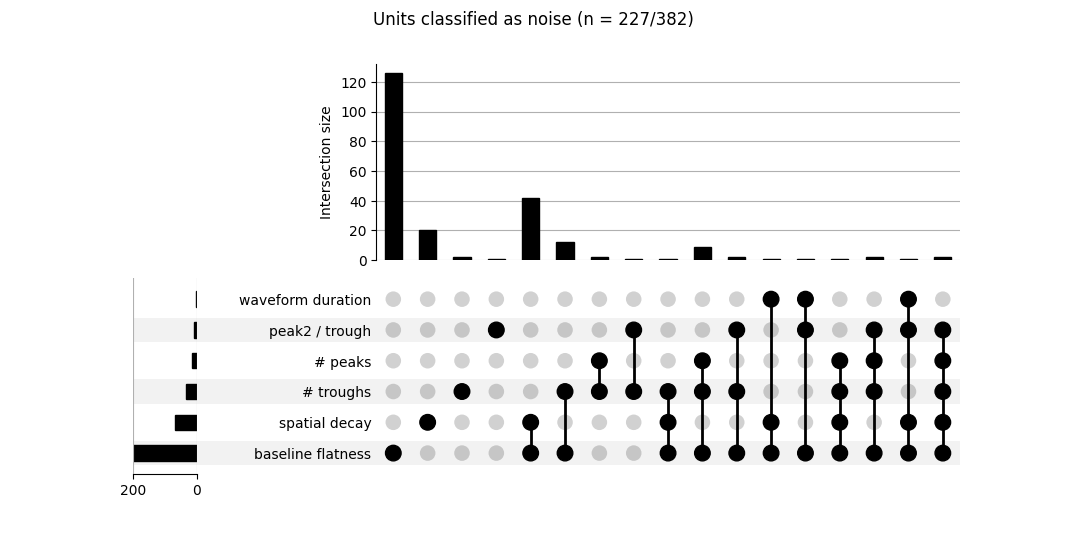

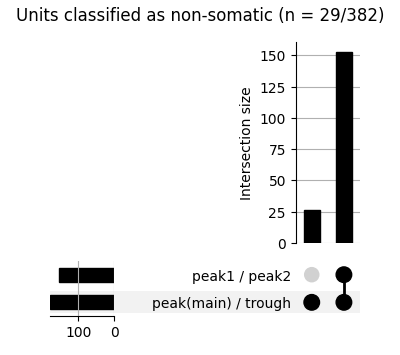

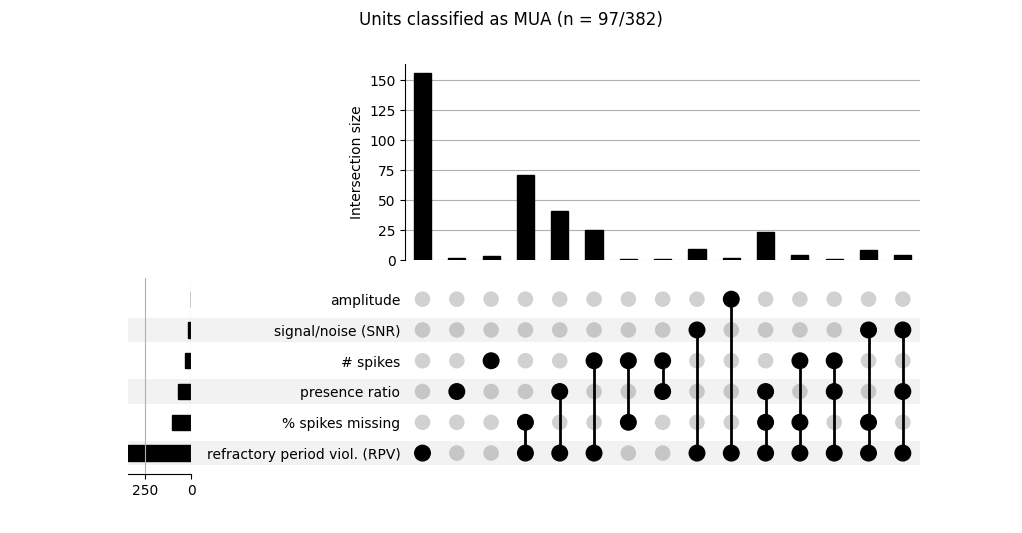

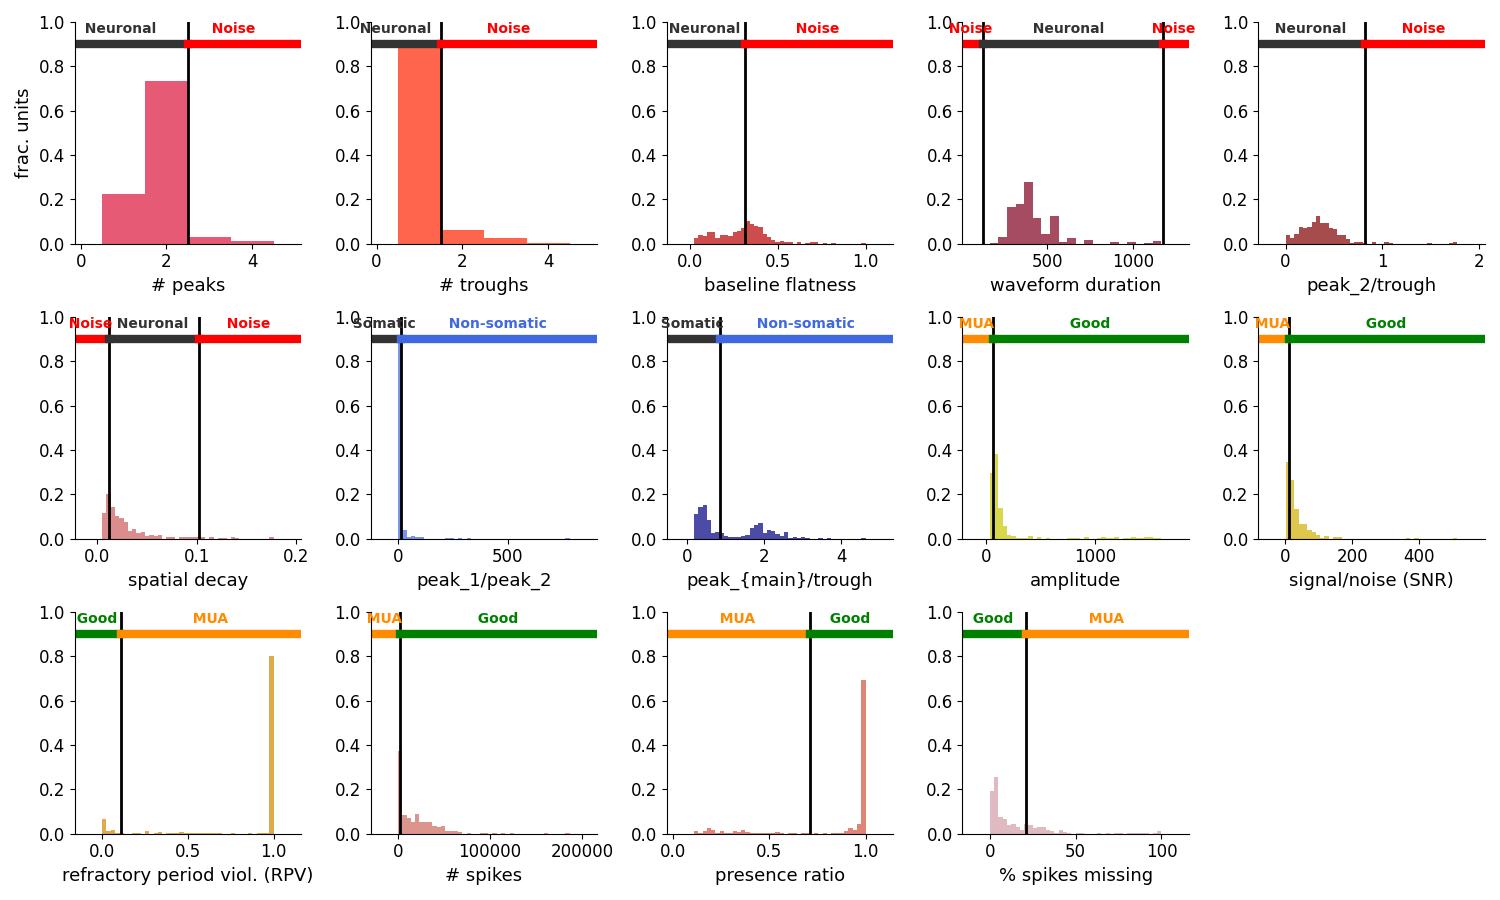


Saving results...
All expected metrics were successfully saved.


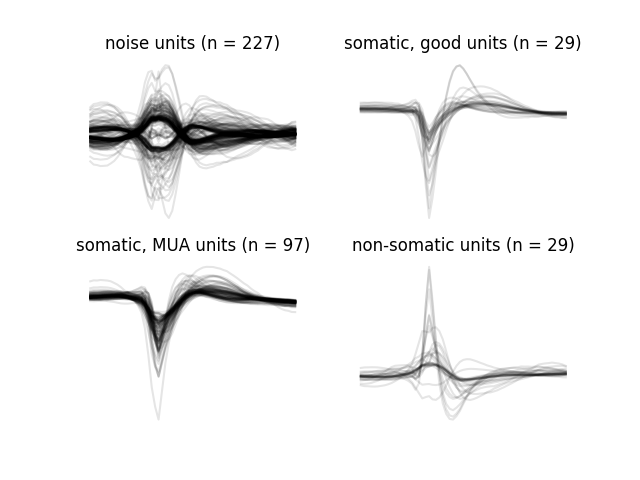

In [5]:

ks_dir = base_path / "sorted" / "sorter_output"
last_part = base_path.name  

imec_dir = base_path / (last_part + "_imec0")
raw_file_path = imec_dir / (last_part + "_t0.imec0.ap.bin")
meta_file_path = imec_dir / (last_part + "_t0.imec0.ap.meta")


# Bombcell output
save_path = ks_dir / "bombcell"



param = bc.get_default_parameters(ks_dir, 
                                  raw_file=raw_file_path,
                                  meta_file=meta_file_path,
                                  kilosort_version=4)
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
    ks_dir, save_path, param
)

# Match Bombcell to SI and Phy

In [6]:

# Read input files
map_df = pd.read_csv(base_path / "sorted" / "phy" / "cluster_si_unit_ids.tsv", sep="\t")
bc_df = pd.read_csv(base_path / "sorted" / "sorter_output" / "bombcell" / "cluster_bc_unitType.tsv", sep="\t")
info_df = pd.read_csv(base_path / "sorted" / "phy" / "cluster_info.tsv", sep="\t")

# Merge by matching Kilosort IDs
merged = map_df.merge(bc_df, left_on="si_unit_id", right_on="cluster_id", how="left")

# Extract labels
phy_labels = merged[["cluster_id_x", "bc_unitType"]].rename(columns={"cluster_id_x": "cluster_id"})

# Merge labels into cluster info
info_df = info_df.merge(phy_labels, on="cluster_id", how="left")

# Optional label overwrite
info_df["group"] = info_df["bc_unitType"]

# Save output files
phy_labels.to_csv(base_path / "sorted" / "phy" / "cluster_bc_unitType.tsv", sep="\t", index=False)
info_df.to_csv(base_path / "sorted" / "phy" / "cluster_info.tsv", sep="\t", index=False)

# find ITI

C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


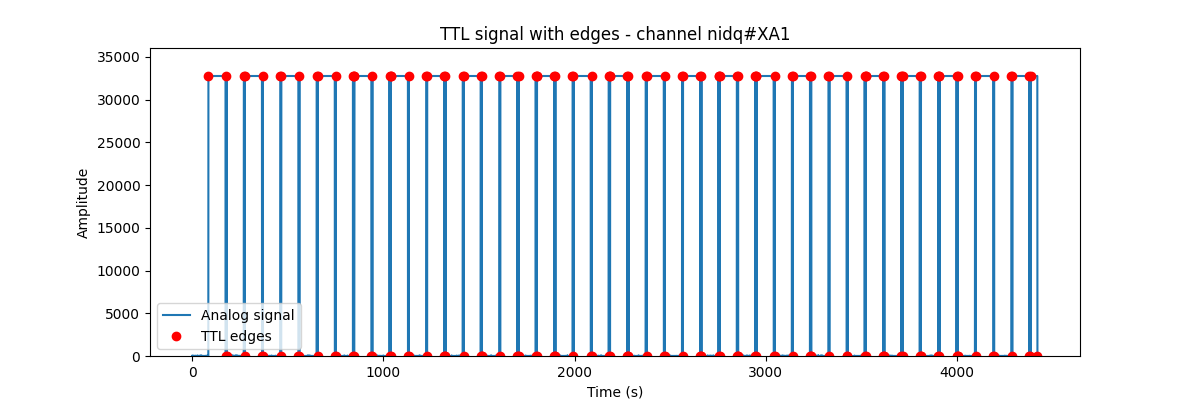

TTL edge times saved to 'ttl_edge_times.csv'


In [7]:

# --- Setup ---
channel_idx = 1  # Adjust as needed
channel_id = event.get_channel_ids()[channel_idx]
sf = event.get_sampling_frequency()

# --- Load entire trace ---
trace = event.get_traces(channel_ids=[channel_id])
signal = trace[:, 0]
time_vector = np.arange(len(signal)) / sf

# --- TTL edge detection ---
def extract_ttl_edges(signal, time_vector, threshold=2000):
    above_threshold = signal > threshold
    changes = np.diff(above_threshold.astype(int))
    
    rising_indices = np.where(changes == 1)[0] + 1
    falling_indices = np.where(changes == -1)[0] + 1

    edge_indices = np.concatenate((rising_indices, falling_indices))
    edge_types = np.array(['rising'] * len(rising_indices) + ['falling'] * len(falling_indices))

    sort_order = np.argsort(edge_indices)
    edge_indices = edge_indices[sort_order]
    edge_types = edge_types[sort_order]

    edge_times = time_vector[edge_indices]

    return edge_times, edge_types, edge_indices

edge_times, edge_types, edge_indices = extract_ttl_edges(signal, time_vector, threshold=100)

# --- Plot with markers ---
plt.figure(figsize=(12, 4))
plt.plot(time_vector, signal, label='Analog signal')
plt.plot(edge_times, signal[edge_indices], 'ro', label='TTL edges')
plt.title(f"TTL signal with edges - channel {channel_id}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.ylim(0, max(signal) * 1.1)
plt.show()

# --- Save to CSV ---
df_edges = pd.DataFrame({
    'time_seconds': edge_times,
    'edge_type': edge_types
})
df_edges.to_csv(metapath / "ttl_edge_times.csv", index=False)
print("TTL edge times saved to 'ttl_edge_times.csv'")



[0 0 0 ... 1 1 1]


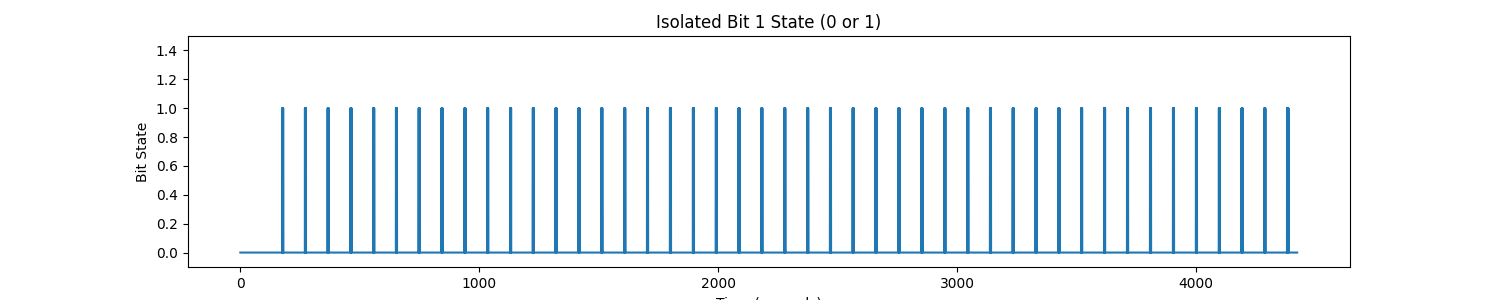

Extracted TTL event timestamps for bit 1 saved to soundttl.csv


In [8]:




def extract_and_save_ttl_events(data, bits, save_path):
    digital_signals = data.get_traces()
    digital_word = digital_signals[:, 8]
    print(digital_word)
    sampling_rate = data.get_sampling_frequency()
    for bit in bits:
        # Extract TTL pulses for the current bit
        ttl_timestamps = extract_ttl_from_bit(digital_word, bit, sampling_rate)
        
        ttl_df = pd.DataFrame(ttl_timestamps, columns=['timestamps'])
        
        filename = f'soundttl.csv'
        
        ttl_df.to_csv(f"{save_path}/{filename}", index=False)
        print(f"Extracted TTL event timestamps for bit {bit} saved to {filename}")


def extract_ttl_from_bit(digital_word, bit, sampling_rate, min_gap_s=5.0):
    """
    Extract and plot TTL bursts, return first rising edge per train.
    """
    ttl_signal = (digital_word >> bit) & 1  # isolate bit
    time_axis = np.arange(len(ttl_signal)) / sampling_rate

    # Plot full or cropped TTL signal
    plt.figure(figsize=(15, 3))
    plt.plot(time_axis, ttl_signal)
    plt.title(f'Isolated Bit {bit} State (0 or 1)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Bit State')
    plt.ylim(-0.1, 1.5)
    #plt.xlim(0, min(time_axis[-1], 10))  # plot first 10 seconds by default
    plt.show()

    # Rising edges (0 → 1)
    rising_indices = np.where(np.diff(ttl_signal) > 0)[0]
    rising_timestamps = rising_indices / sampling_rate

    # Detect first rising edge of each train
    if len(rising_timestamps) == 0:
        return np.array([])

    first_in_trains = [rising_timestamps[0]]
    for i in range(1, len(rising_timestamps)):
        if rising_timestamps[i] - rising_timestamps[i - 1] > min_gap_s:
            first_in_trains.append(rising_timestamps[i])

    return np.array(first_in_trains)



bits_to_extract = [1]  
extract_and_save_ttl_events(event , bits_to_extract, metapath)






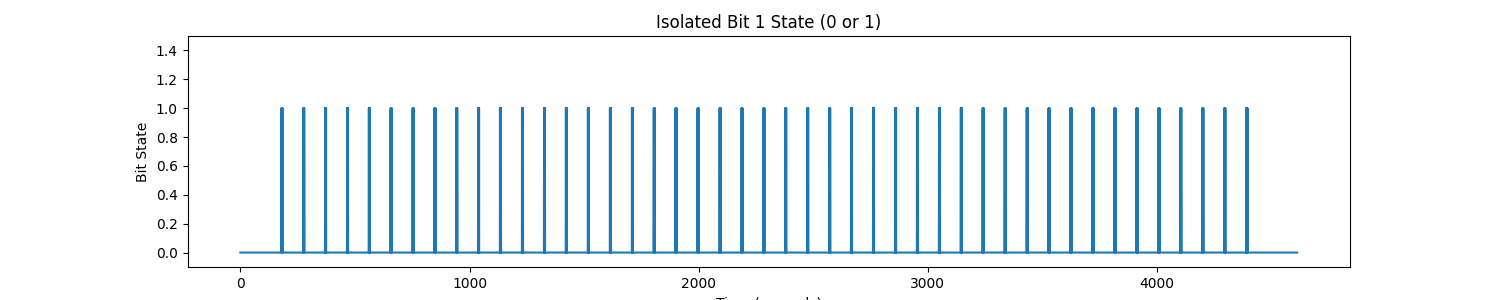

In [9]:
def extract_ttl_from_bit(digital_word, bit, sampling_rate, min_gap_s=5.0):
    """
    Extract and plot TTL bursts, return first rising edge per train.
    """
    ttl_signal = (digital_word >> bit) & 1  # isolate bit
    time_axis = np.arange(len(ttl_signal)) / sampling_rate

    # Plot full or cropped TTL signal
    plt.figure(figsize=(15, 3))
    plt.plot(time_axis, ttl_signal)
    plt.title(f'Isolated Bit {bit} State (0 or 1)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Bit State')
    plt.ylim(-0.1, 1.5)
    #plt.xlim(1614, 1614.5) # plot first 10 seconds by default
    plt.show()

    # Rising edges (0 → 1)
    rising_indices = np.where(np.diff(ttl_signal) > 0)[0]
    rising_timestamps = rising_indices / sampling_rate

    # Detect first rising edge of each train
    if len(rising_timestamps) == 0:
        return np.array([])

    first_in_trains = [rising_timestamps[0]]
    for i in range(1, len(rising_timestamps)):
        if rising_timestamps[i] - rising_timestamps[i - 1] > min_gap_s:
            first_in_trains.append(rising_timestamps[i])

    return np.array(first_in_trains)

digital_signals = event.get_traces()
digital_word = digital_signals[:, 8]
sampling_rate = event.get_sampling_frequency()
ttl_timestamps = extract_ttl_from_bit(digital_word, 1, sampling_rate)
        
   

# phy

In [9]:
param_path = f"{basefolder}\\sorted\\phy\\params.py"
!phy template-gui "{param_path}"

10:41:50.354 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
10:42:02.972 [I] supervisor:711       Change metadata_group for clusters 15 to good.
10:42:09.371 [I] supervisor:711       Change metadata_group for clusters 28 to good.
10:42:11.560 [I] supervisor:711       Change metadata_group for clusters 29 to good.
10:42:42.163 [I] supervisor:711       Change metadata_group for clusters 33 to good.
10:42:45.054 [I] supervisor:711       Change metadata_group for clusters 35 to good.
10:42:47.916 [I] supervisor:711       Change metadata_group for clusters 37 to good.
10:42:50.323 [I] supervisor:711       Change metadata_group for clusters 39 to good.
10:42:52.167 [I] supervisor:711       Change metadata_group for clusters 42 to good.
10:42:54.184 [I] supervisor:711       Change metadata_group for clusters 46 to good.
10:42:56.155 [I] supervisor:711       Change metadata_group for clusters 49 to good.
10:42

# transfer to meta

In [10]:
src = base_path / "sorted" / "phy" / "cluster_info.tsv"
dst = metapath / "cluster_info.tsv"
shutil.copy2(src, dst)


WindowsPath('D:/Data/3198-52/3198-52_recall_g0/Meta/cluster_info.tsv')

# optional